## Diagnostics

In [72]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.colors as colors
from matplotlib import axes
# from datetime import timedelta
import cartopy.feature as cfeature


import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import dask, dask.distributed
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(cores=8,memory='50GB',processes=1,queue='large96:shared', walltime='3:00:00',interface='ib0',local_directory='$TMPDIR')
client = dask.distributed.Client(cluster)
cluster.scale(jobs=8)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.246.8.3:8787/status,
Dashboard: http://10.246.8.3:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.246.8.3:45701,Workers: 0
Dashboard: http://10.246.8.3:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [121]:
test = xr.open_dataset('/scratch/usr/shkifmmp/manusc/data/EXP05/wind/1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05_5d_19580101_19581231_grid_TAU.nc')

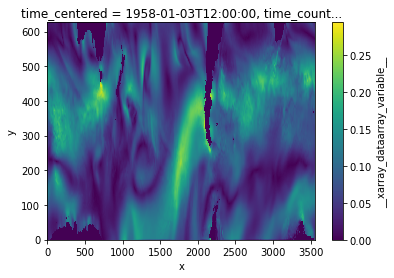

In [125]:
test.__xarray_dataarray_variable__.isel(time_counter=0).plot()

### loading data

In [2]:
# mask
meshpath = ['/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/1_mesh_mask.nc']
mask_10 = xr.open_dataset(meshpath[0], chunks={"y":100, "x":100}).tmask.isel(z=0).squeeze()
mask_10_base = xr.open_dataset('/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/mesh_mask.nc', chunks={"y":100, "x":100}).tmask.isel(z=0).squeeze()
e0t = xr.open_dataset(meshpath[0], chunks={"y":100, "x":100}).isel(t=0)[['e1t','e2t']].squeeze()

# observational data
obs_path = '/scratch/usr/shkifmmp/master/data/observations/'

# DATA DETECTION
datapath= '/scratch/usr/shkifmmp/manusc/data/'

# Path to Lavinia's folder
path_05_old = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT/'#Drake/'
path_06 = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP06/OUT/'

# DATA DETECTION
datapath= '/scratch/usr/shkifmmp/manusc/data/'

# acc mask - FOR DETECTION ONLY
# mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/interpolated/int_mask_regions.nc').mask_regions

# acc mask -normal plotting and computation
mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/mask/mask_nest_int_2d.nc', chunks={"y":100, "x":100}).mask_nest

In [65]:
mask_plot = mask_acc.where(mask_acc ==0, other=1)

mask_plot = mask_plot.where(mask_plot.nav_lat >= -65, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon > 75.5, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon < 431.58, other=0)

In [162]:
e0v = xr.open_dataset(meshpath[0], chunks={"y":100, "x":100}).isel(t=0)[['e1v','e2v']].squeeze()

In [6]:
# for auxiliary calculation only
lat_aux = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/EKE/1*2002*EKE_k10.nc')), chunks = {"y": 100, "x":100}).nav_lat.squeeze()

In [35]:
# (((155*1e3)**2)*np.pi)/(8647.995188**2) # r**2 * pi / (e1f*e2f) # gives the number of pixels

1009.2119642438435

In [37]:
# (np.sqrt(((8647.995188**2) * 1038) /np.pi) * 2) /1e3 #reversed calculation, giving pixels and e1f,e2f, gives back the diameter of the eddy that could be found

314.39032695704515

### EKE 

### time series

In [9]:
#nest
eke_6 = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/EKE/1*EKE_k10.nc')), chunks = {"y": 100, "x":100}).vozocrtx.squeeze().where(mask_10)

In [39]:
eke_6 = eke_6.isel(x=slice(1,-1), y=slice(1,-1))

In [10]:
eke_5 = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP05/EKE_nest/1*EKE_k10.nc')), chunks={"y":100, "x":100}).vozocrtx.squeeze().where(mask_10)

In [48]:
eke_5 = eke_5.isel(x=slice(1,-1), y=slice(1,-1))

In [17]:
eke_6w = eke_6.where((eke_6.nav_lat >= -67) & (eke_6.nav_lat <= -30),drop=True)

In [18]:
eke_5w = eke_5.where((eke_5.nav_lat >= -67) & (eke_5.nav_lat <= -30),drop=True)

#### weighted mean

In [51]:
def weighted_mean(variable, weight, mask=None): #check this None if it works
    variable = variable.where(mask)
    weight = weight.where(mask)
    return (variable * weight).sum(('x','y')) / weight.sum(('x','y'))

In [19]:
area = (e0t.e1t * e0t.e2t).where((lat_aux.nav_lat >= -67) & (lat_aux <= -30),drop=True).compute()

In [23]:
# whole region
eke6_wmean = weighted_mean(eke_6w, area).compute()

eke5_wmean = weighted_mean(eke_5w, area).compute()

In [49]:
area_acc = (e0t.e1t * e0t.e2t).isel(x=slice(1,-1), y=slice(1,-1))

In [52]:
# within acc mask
eke6_acc = weighted_mean(eke_6, area_acc, mask_acc).compute()

In [53]:
eke5_acc = weighted_mean(eke_5, area_acc, mask_acc).compute()

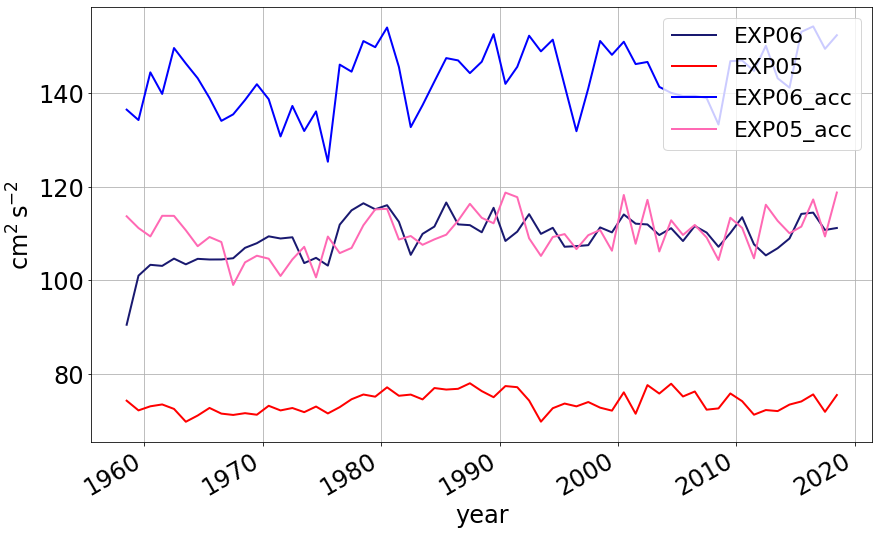

In [65]:
fig, axs = plt.subplots(figsize=(14,8))

(eke6_wmean*1e4).plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
(eke5_wmean*1e4).plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

(eke6_acc*1e4).plot(ax=axs, label='EXP06_acc', color='blue', linewidth=2)
(eke5_acc*1e4).plot(ax=axs, label= 'EXP05_acc', color='hotpink', linewidth=2)

# axs.axvline(x=dt.datetime(1978,7,1), color='k', linestyle='--', linewidth=2)
# axs.axvline(x=dt.datetime(1998,7,1), color='k', linestyle='--', linewidth=2)
axs.set_title(None)
axs.tick_params(axis= 'x', labelsize= 24)
axs.tick_params(axis= 'y', labelsize= 24)
axs.set_xlabel('year', fontsize=24)
# axs.set_ylabel('EKE at 100m (cm$^{2}\,$s$^{-2}$)', fontsize=24)
axs.set_ylabel('cm$^{2}\,$s$^{-2}$', fontsize=24)
axs.grid()

plt.legend(fontsize=22)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(save_path + 'eke_timeseries.png', format='png', facecolor="w",  bbox_inches='tight')

### maps

In [8]:
eke_6_b = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP06/EKE/O*199[3-9]*EKE*') +
                                          glob(datapath + 'EXP06/EKE/O*_20*EKE*')),
                           chunks={'y':100, 'x':100}).vozocrtx.squeeze().where(mask_10_base)

In [11]:
eke_6_n = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP06/EKE/1*199[3-9]*EKE*') +
                                          glob(datapath + 'EXP06/EKE/1*_20*EKE*')),
                           chunks={'y':100, 'x':100}).vozocrtx.squeeze().where(mask_10)

In [13]:
eke_5_b = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP05/EKE_base/O*199[3-9]*EKE*') +
                                          glob(datapath + 'EXP05/EKE_base/O*_20*EKE*')),
                           chunks={'y':100, 'x':100}).vozocrtx.squeeze().where(mask_10_base)

In [14]:
eke_5_n = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP05/EKE_nest/1*199[3-9]*EKE*') +
                                          glob(datapath + 'EXP05/EKE_nest/1*_20*EKE*')),
                           chunks={'y':100, 'x':100}).vozocrtx.squeeze().where(mask_10)

#### correcting discontinuity

In [47]:
eke_6_b.coords["x"], eke_6_b.coords["y"] = range(len(eke_6_b.x)), range(len(eke_6_b.y))

eke_5_b.coords["x"], eke_5_b.coords["y"] = range(len(eke_5_b.x)), range(len(eke_5_b.y))

after_discont_base = ~(eke_6_b.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

eke_6_b.coords["nav_lon"] = (
    eke_6_b.coords["nav_lon"]
    + 360 * after_discont_base)

eke_5_b.coords["nav_lon"] = (
    eke_5_b.coords["nav_lon"]
    + 360 * after_discont_base)

eke_6_b = eke_6_b.isel(x=slice(1,None))

eke_5_b = eke_5_b.isel(x=slice(1,None))

In [48]:
eke_6_n.coords["x"], eke_6_n.coords["y"] = range(len(eke_6_n.x)), range(len(eke_6_n.y))

eke_5_n.coords["x"], eke_5_n.coords["y"] = range(len(eke_5_n.x)), range(len(eke_5_n.y))

after_discont = ~(eke_6_n.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

eke_6_n.coords["nav_lon"] = (
    eke_6_n.coords["nav_lon"]
    + 360 * after_discont)

eke_5_n.coords["nav_lon"] = (
    eke_5_n.coords["nav_lon"]
    + 360 * after_discont)

eke_6_n = eke_6_n.isel(x=slice(1,None))

eke_5_n = eke_5_n.isel(x=slice(1,None))

In [69]:
eke_6n_mean = eke_6_n.mean(dim = 'time_counter').compute()

eke_5n_mean = eke_5_n.mean(dim = 'time_counter').compute()

In [70]:
eke_6b_mean = eke_6_b.mean(dim = 'time_counter').compute()

eke_5b_mean = eke_5_b.mean(dim = 'time_counter').compute()

In [89]:
mask_acc.isel(y=0).nav_lon[-1].values

array(431.59999847)

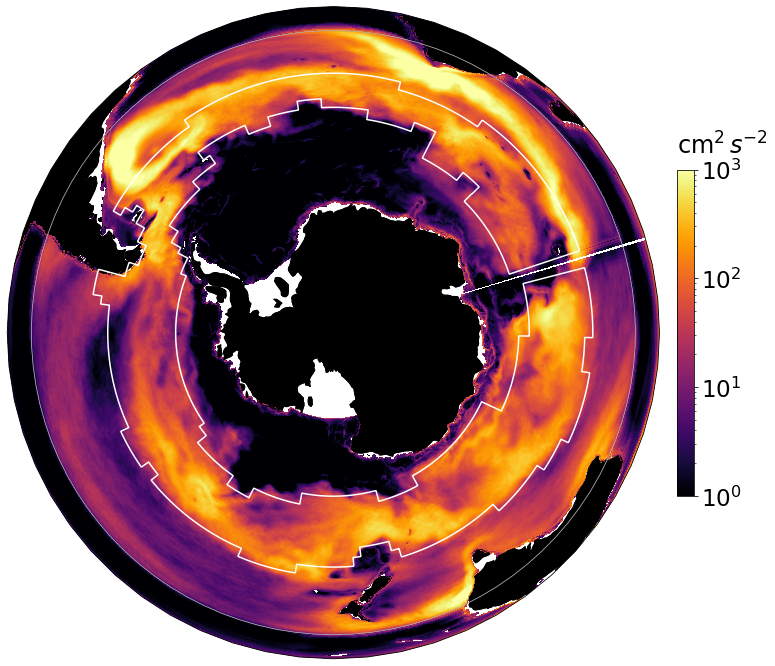

In [113]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

# levs = np.hstack((np.arange(0, 0.1, 0.05), np.arange(0.1,  0.4, 0.1)))
# norm = colors.BoundaryNorm(boundaries=levs, ncolors=356)

map1 = (eke_6n_mean*1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 3,
                               add_colorbar= False, norm=colors.LogNorm(vmin=1e-0, vmax=1000), 
                       cmap= 'inferno')

(eke_6b_mean*1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False, norm=colors.LogNorm(vmin=1e-0, vmax=1000),
                               cmap = 'inferno')

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='white', levels=[1], linewidth=15, zorder=5)

axs.gridlines(ylocs=[-30], zorder=7, colors='white').xlines = False

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=24, y=1.03)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c.ax.tick_params(labelsize=23)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=24)

axs.set_title(None)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
# plt.savefig(savepath + 'eke_9318_map_EXP06.png', format='png', facecolor="w", bbox_inches='tight')

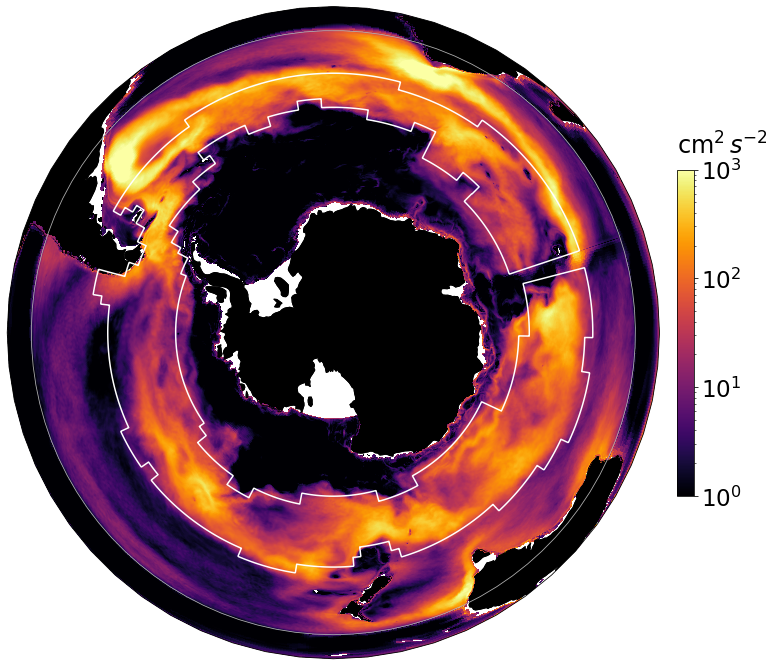

In [114]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

# levs = np.hstack((np.arange(0, 0.1, 0.05), np.arange(0.1,  0.4, 0.1)))
# norm = colors.BoundaryNorm(boundaries=levs, ncolors=356)

map1 = (eke_5n_mean*1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 3,
                               add_colorbar= False, norm=colors.LogNorm(vmin=1e-0, vmax=1000), 
                       cmap= 'inferno')

(eke_5b_mean*1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False, norm=colors.LogNorm(vmin=1e-0, vmax=1000),
                               cmap = 'inferno')

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='white', levels=[1], linewidth=15, zorder=5)

axs.gridlines(ylocs=[-30], zorder=7, colors='white').xlines = False

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=24, y=1.03)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c.ax.tick_params(labelsize=23)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=24)

axs.set_title(None)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(savepath + 'eke_9318_map_EXP05.png', format='png', facecolor="w", bbox_inches='tight')

/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/shkifmmp/miniconda3/envs/py3_eddy/lib/pyth

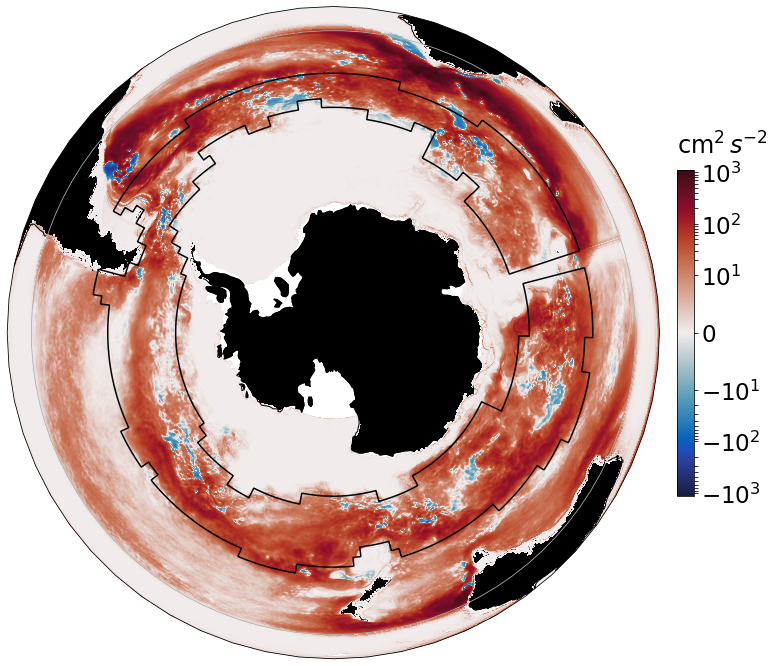

In [120]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

# levs = np.hstack((np.arange(0, 0.1, 0.05), np.arange(0.1,  0.4, 0.1)))
# norm = colors.BoundaryNorm(boundaries=levs, ncolors=356)

map1 = (eke_6n_mean*1e4 - eke_5n_mean*1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 3,
                               add_colorbar= False, norm=colors.SymLogNorm(linthresh=1e1),
                       cmap= cm.balance)

(eke_6b_mean*1e4 - eke_5b_mean*1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False, norm=colors.SymLogNorm(linthresh=1e1),
                               cmap = cm.balance)

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=5)

axs.gridlines(ylocs=[-30], zorder=7, colors='white').xlines = False

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=24, y=1.03)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c.ax.tick_params(labelsize=23)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=24)

axs.set_title(None)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(savepath + 'eke_9318_map_diff_log.png', format='png', facecolor="w", bbox_inches='tight')

### ACC strength

In [81]:
drake_05 = xr.open_mfdataset(paths = sorted(glob(path_05_old + 'Drake/1_*1958*2017*transports.nc') + 
                            glob(datapath + 'EXP05/1_*2018*transports.nc'))).vtrp.squeeze()

In [83]:
drake_06 = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/drake_transp/1_*transports.nc'))).vtrp.squeeze()

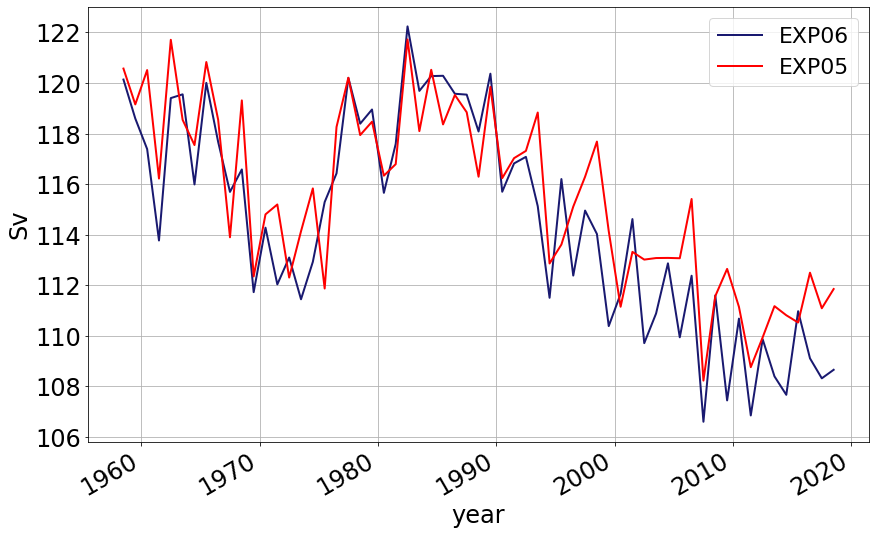

In [88]:
fig, axs = plt.subplots(figsize=(14,8))

drake_06.plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
drake_05.plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

# axs.axvline(x=dt.datetime(1978,7,1), color='k', linestyle='--', linewidth=2)
# axs.axvline(x=dt.datetime(1998,7,1), color='k', linestyle='--', linewidth=2)
axs.set_title(None)
axs.tick_params(axis= 'x', labelsize= 24)
axs.tick_params(axis= 'y', labelsize= 24)
axs.set_xlabel('year', fontsize=24)
# axs.set_ylabel('EKE at 100m (cm$^{2}\,$s$^{-2}$)', fontsize=24)
axs.set_ylabel('Sv', fontsize=24)
axs.grid()

plt.legend(fontsize=22)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(save_path + 'drake_timeseries.png', format='png', facecolor="w",  bbox_inches='tight')

### Wind stress

master way

In [7]:
wind_u_5 = xr.open_mfdataset(paths=sorted(glob(path_05_old + '1_*5d*0101*1231*grid_U*')),
                         chunks={'y':100, 'x':100}).sozotaux.squeeze()

wind_u_5 = wind_u_5.isel(x=slice(1,-1), y=slice(1,-1))

wind_v_5 = xr.open_mfdataset(paths=sorted(glob(path_05_old + '1_*5d*0101*1231*grid_V*')),
                         chunks={'y':100, 'x':100}).sometauy.squeeze()

wind_v_5 = wind_v_5.isel(x=slice(1,-1), y=slice(1,-1))

# ws_05_O = np.abs(np.sqrt(wind_u_5**2 + wind_v_5**2))

In [ ]:
ws_05_O = np.sqrt(wind_u_5**2 + wind_v_5**2).compute()

In [ ]:
# ws_05_O = np.abs(np.sqrt(wind_u_5**2 + wind_v_5**2)).compute()

In [ ]:
# ws_05_O.to_netcdf(path=datapath + 'EXP05/wstress_masterway.nc')

In [ ]:
# wind_u_6 = xr.open_mfdataset(paths=sorted(glob(path_06 + '1_*5d*0101*1231*grid_U*')),
#                          chunks={'y':100, 'x':100}).sozotaux.squeeze()

# wind_u_6 = wind_u_6.isel(x=slice(1,-1), y=slice(1,-1))

# wind_v_6 = xr.open_mfdataset(paths=sorted(glob(path_06 + '1_*5d*0101*1231*grid_V*')),
#                          chunks={'y':100, 'x':100}).sometauy.squeeze()

# wind_v_6 = wind_v_6.isel(x=slice(1,-1), y=slice(1,-1))

# ws_06_O = np.abs(np.sqrt(wind_u_6**2 + wind_v_6**2)).compute()

In [ ]:
# ws_06_O.to_netcdf(path=datapath + 'EXP06/wstress_masterway.nc')

In [104]:
ws_05 = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP05/wind/1_*tot_wnd.nc')),
                         chunks={'y':100, 'x':100}).vomecrty.squeeze()

In [123]:
ws_06 = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/wind/1_*tot_wnd.nc')),
                         chunks={'y':100, 'x':100}).vomecrty.squeeze()

In [106]:
ws_05 = ws_05.isel(x=slice(1,-1), y=slice(1,-1))

In [124]:
ws_06 = ws_06.isel(x=slice(1,-1), y=slice(1,-1))

In [108]:
ws_6w = ws_06.where((ws_06.nav_lat >= -67) & (ws_06.nav_lat <= -30),drop=True)

/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [110]:
ws_5w = ws_05.where((ws_05.nav_lat >= -67) & (ws_05.nav_lat <= -30),drop=True)

/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [179]:
ws_06_ym = ws_06.groupby("time_counter.year").mean()

ws_05_ym = ws_05.groupby("time_counter.year").mean()

ws_6w_ym = ws_6w.groupby("time_counter.year").mean()

ws_5w_ym = ws_5w.groupby("time_counter.year").mean()

In [186]:
ws_06_acc = weighted_mean(ws_06_ym, area_acc, mask_acc).compute()

# ws_06_acc.to_netcdf(path=datapath + 'EXP06/wstress_acc_timeseries.nc')

ws_06_mw = weighted_mean(ws_6w_ym, area.isel(y=slice(None,-1),x=slice(1,-1))).compute()

# ws_06_mw.to_netcdf(path=datapath + 'EXP06/wstress_whole_timeseries.nc')

ws_05_mw = weighted_mean(ws_5w_ym, area.isel(y=slice(None,-1),x=slice(1,-1))).compute()

# ws_05_mw.to_netcdf(path=datapath + 'EXP05/wstress_whole_timeseries.nc')

ws_05_acc = weighted_mean(ws_05_ym, area_acc, mask_acc).compute()

# ws_05_acc.to_netcdf(path=datapath + 'EXP05/wstress_acc_timeseries.nc')

In [193]:
ws_05_acc = ws_05_acc.rename({'year':'time_counter'})

ws_06_acc = ws_06_acc.rename({'year':'time_counter'})

ws_05_mw = ws_05_mw.rename({'year':'time_counter'})

ws_06_mw = ws_06_mw.rename({'year':'time_counter'})

In [195]:
ws_06_mw

<xarray.DataArray (time_counter: 60)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    depthv        float32 3.047
  * time_counter  (time_counter) int64 1958 1959 1960 1961 ... 2016 2017 2018

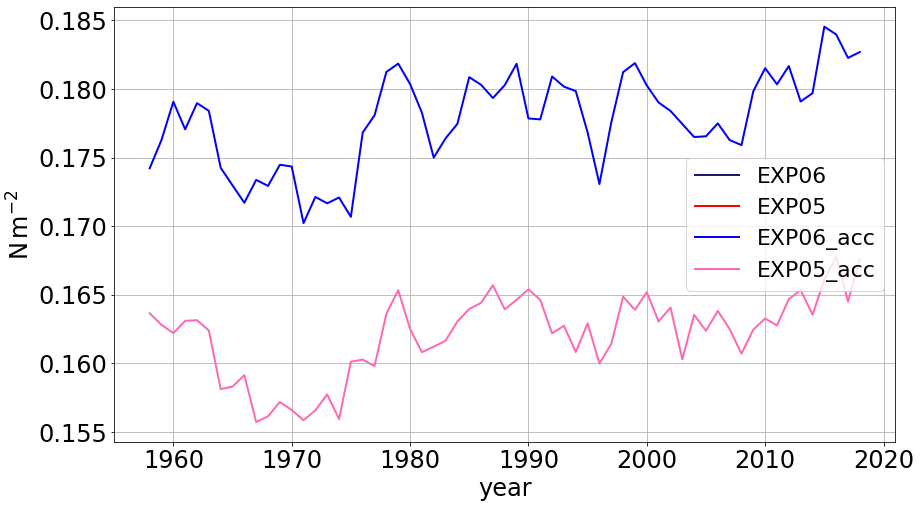

In [194]:
fig, axs = plt.subplots(figsize=(14,8))

ws_06_mw.plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
ws_05_mw.plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

ws_06_acc.plot(ax=axs, label='EXP06_acc', color='blue', linewidth=2)
ws_05_acc.plot(ax=axs, label= 'EXP05_acc', color='hotpink', linewidth=2)

# axs.axvline(x=dt.datetime(1978,7,1), color='k', linestyle='--', linewidth=2)
# axs.axvline(x=dt.datetime(1998,7,1), color='k', linestyle='--', linewidth=2)
axs.set_title(None)
axs.tick_params(axis= 'x', labelsize= 24)
axs.tick_params(axis= 'y', labelsize= 24)
axs.set_xlabel('year', fontsize=24)
# axs.set_ylabel('EKE at 100m (cm$^{2}\,$s$^{-2}$)', fontsize=24)
axs.set_ylabel('N$\,$m$^{-2}$', fontsize=24)
axs.grid()

plt.legend(fontsize=22)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
# plt.savefig(save_path + 'eke_timeseries.png', format='png', facecolor="w",  bbox_inches='tight')

### Wind work

In [7]:
u05 = xr.open_mfdataset(paths = sorted(glob(path_05 + '1_*_5d_*0101*1231*_grid_U.nc')), 
                          chunks={'y':100, 'x': 100}).vozocrtx.isel(depthu=0).where(mask_10)

In [8]:
v05 = xr.open_mfdataset(paths = sorted(glob(path_05 + '1_*_5d_*0101*1231*_grid_V.nc')), 
                          chunks={'y':100, 'x': 100}).vomecrty.isel(depthv=0).where(mask_10)

In [9]:
U_05 = np.abs(np.sqrt(u05**2 + v05**2))

wind work = tau * Uo

In [20]:
wind_work_05 = xr.open_dataset('/scratch/usr/shkifmmp/manusc/data/EXP06/wind/1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP06_5d_19580101_19581231_grid_wnd_work.nc').where(mask_10)

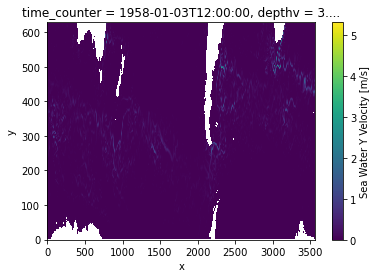

In [21]:
wind_work_05.vomecrty.isel(time_counter=0).plot()

In [17]:
wind_work_05 = wind_work_05.chunk({'time_counter': 1000, 'x':1001, 'y':629})

In [ ]:
with ProgressBar():
    wind_work_05.to_netcdf(path=datapath + 'EXP05/wind_work.nc')

[########################################] | 100% Completed |  0.1s
[                                        ] | 0% Completed |  3min 25.5s

In [18]:
datapath

'/scratch/usr/shkifmmp/manusc/data/'